In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import yaml
from networkx.algorithms import approximation as nx_approx
from tqdm.notebook import tqdm
from copy import deepcopy
# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'

# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history

In [2]:
my_config = yaml.safe_load(open("fitted_config.yaml"))
my_config["population"]["population class"] = "NetworkXPopulation"
my_config["population"]["nx"] = {}
my_config["population"]["nx"]["func"] = "lfr_ba"
my_config["population"]["nx"]["kwargs"] = {
                "m": 5,
                "tau": 1.2,
                "mu": 0.1,
                "min_community": 10,
                "max_community": 500,
                "max_iters": 2000,
                "tolerance": 0.1,
                "pref_attach": True
            }
my_config["population"]["nx"]["inter freq pdf"] = {
                "class": "Gamma",
                "mean": 7.8,
                "sd": 3
            }
my_config["population"]["nx"]["intra freq pdf"] = { 
                "class": "Gamma",
                "mean": 7.8,
                "sd": 3
            }
my_config["population"]["random interactions pdf"] = {"class": "Delta"}



In [3]:
#contagion = Contagion(my_config)
my_config["population"]["store_population"] = False
my_config["population"]["re-use population"] = False

In [10]:
class ParScan(object):
    def __init__(self, conf):
        self._conf = conf
        self._par_range = None
        
    def par_update(self, val):
        pass
    
    def __iter__(self):
        for par in self._par_range:
            yield self.par_update(par)

class ScanMu(ParScan):
    
    def __init__(self, conf):
        super().__init__(conf)
        self._par_range = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7]
        self.par_name = "Mu"
        self.title = "Fraction of external connections"
        
    def par_update(self, par):
        conf = deepcopy(self._conf)        
        conf["population"]["nx"]["kwargs"]["mu"] = par
        return conf
    
class ScanM(ParScan):
    
    def __init__(self, conf):
        super().__init__(conf)
        self._par_range = [1, 2, 3, 4, 5, 8]
        self.par_name = "m"
        self.title = "Min. Node Degree"

        
    def par_update(self, par):
        conf = deepcopy(self._conf)
        
        conf["population"]["nx"]["kwargs"]["m"] = par
        return conf
    
class ScanIntraInterRatio(ParScan):
    
    def __init__(self, conf, target_avg=7.8, mu=0.1):
        super().__init__(conf)
        self._par_range = [0.1, 0.5, 1, 2, 5, 10]
        self.par_name = "ratio"
        self.title = "Ratio of Intra to Inter Community Interaction"
        self.target_avg = target_avg
        self.mu = mu

        
    def par_update(self, par):
        conf = deepcopy(self._conf)
        conf["population"]["nx"]["kwargs"]["mu"] = self.mu
        a = self.target_avg / (self.mu + (1-self.mu)*par)
        b = par * a
        conf["population"]["nx"]["inter freq pdf"]["mean"] = a
        conf["population"]["nx"]["intra freq pdf"]["mean"] = b

        return conf
    
class ScanPrefAttachMu(ParScan):
    
    def __init__(self, conf):
        super().__init__(conf)
        self._par_range = [(0.05, True), (0.1, True), (0.3, True),
                           (0.05, False), (0.1, False), (0.3, False)]
        
        self.par_name = "Mu, Pref. Attach."
        self.title = "Mu / Preferential Attachment"

        
    def par_update(self, par):
        conf = deepcopy(self._conf)
        
        conf["population"]["nx"]["kwargs"]["mu"] = par[0]
        conf["population"]["nx"]["kwargs"]["pref_attach"] = par[1]
        return conf
    
class ScanRndInt(ParScan):
    def __init__(self, conf, base_rate=1):
        super().__init__(conf)
        self._par_range = [0.1, 0.5, 1, 2, 10]
        
        self.par_name = "ratio"
        self.title = "Num Rnd Cont / Rnd Cont Str"
        self.base_rate = base_rate

        
    def par_update(self, par):
        conf = deepcopy(self._conf)
        conf["population"]["random interactions pdf"]["mean"] = par * self.base_rate
        conf["population"]["random interactions intensity pdf"]["mean"] =  self.base_rate / par


        return conf
        


def plot_infection(all_results, scan):
    fig, axs = plt.subplots(2,3, figsize=(15, 10))
    for results, ax, scan_par in zip(all_results, axs.ravel(), scan._par_range):
        for res, _ in results:
            ax.plot(np.arange(len(res['is_infected'])), res['is_infected'],
                    lw=2, alpha=0.5)
    #ax.set_yscale("log")
            ax.set_xlabel("t [days]")
            ax.set_ylabel("Infected")
            ax.set_ylim(0, 8000)
            ax.set_xlim(0, 350)
            ax.set_title("{} : {}".format(scan.par_name, scan_par))
    fig.suptitle(scan.title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig(PICS + "lfr_ba_par_scan_mu.png", dpi=150)
    

In [13]:
scan = ScanRndInt(my_config)
all_results_rndint = []
for conf in tqdm(scan):
    results = []
    for i in range(10):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_rndint.append(results)


Max community is smaller than max(k)+1. Adjusting
Max community is smaller than max(k)+1. Adjusting
Max community is smaller than max(k)+1. Adjusting
Max community is smaller than max(k)+1. Adjusting
Max community is smaller than max(k)+1. Adjusting



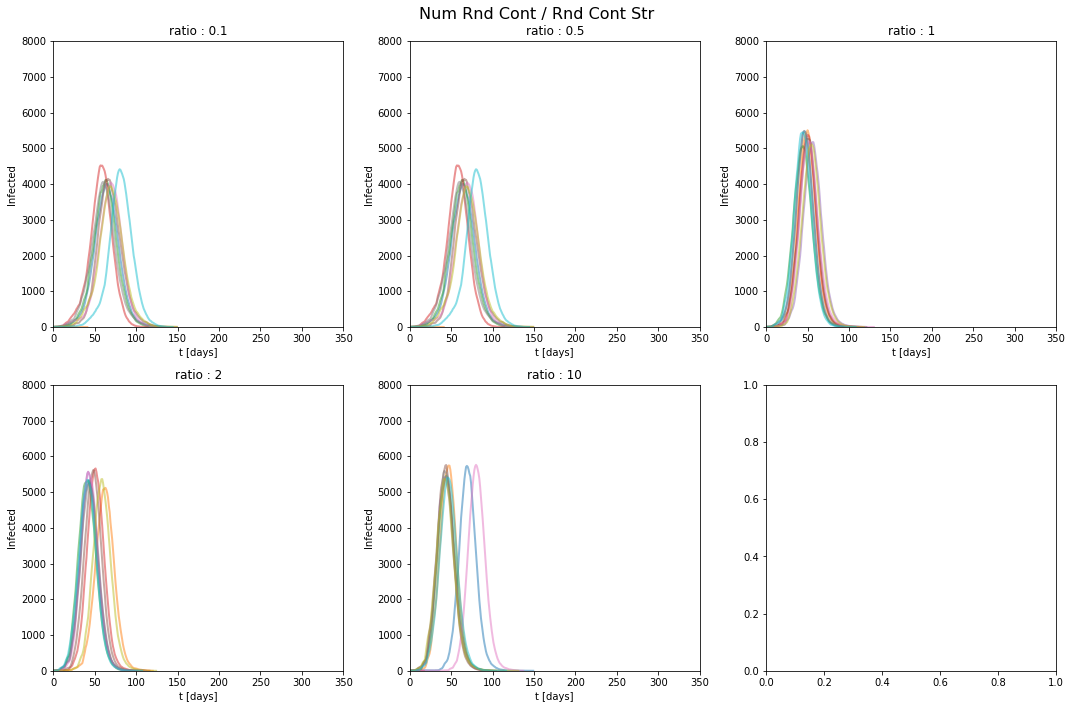

In [14]:
plot_infection(all_results_rndint, scan)

In [9]:
scan = ScanMu(my_config)
all_results_mu = []
for conf in tqdm(scan):
    print("New step")
    results = []
    for i in range(5):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_mu.append(results)


New step
No change for five steps. Current mu:  0.011304417541890488  Target:  0.01
No change for five steps. Current mu:  0.010563027399731362  Target:  0.01
No change for five steps. Current mu:  0.011102871916147228  Target:  0.01
No change for five steps. Current mu:  0.010802036153753636  Target:  0.01
No change for five steps. Current mu:  0.011704110467563145  Target:  0.01
New step
No change for five steps. Current mu:  0.05050120288692861  Target:  0.05
New step
New step
New step
New step



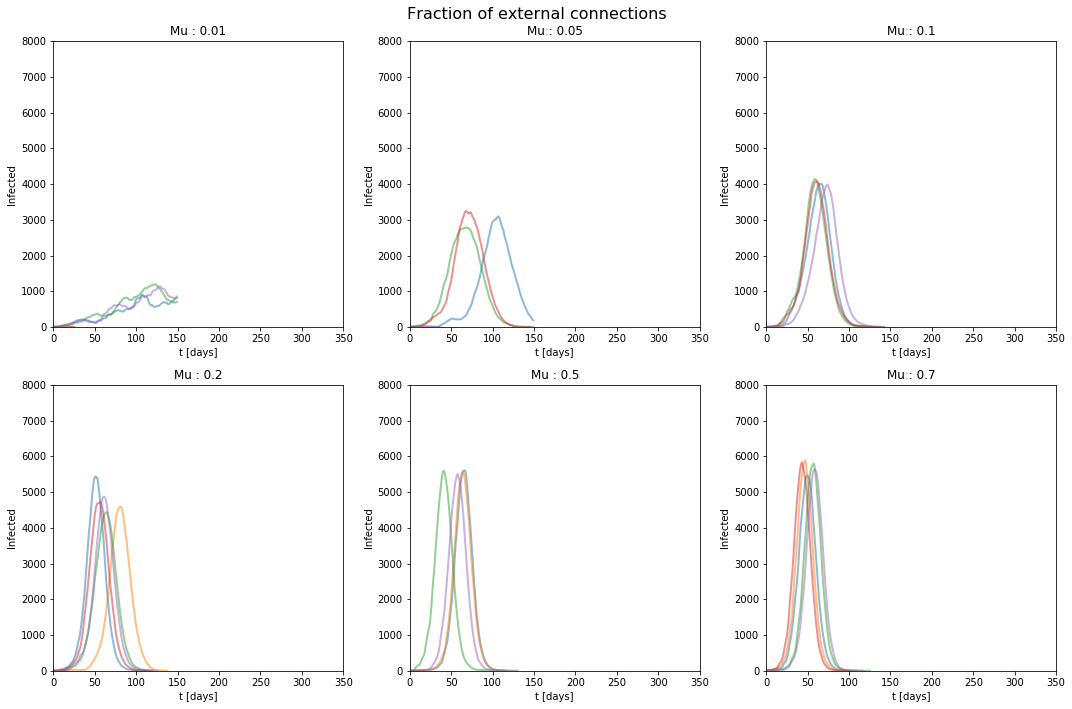

In [10]:
plot_infection(all_results_mu, scan)

In [18]:
for res, par in zip(all_results_mu, scan._par_range):
    for _, g in res:
        #comps = [g.subgraph(c) for c in nx.connected_components(g)]
        #avg_pl = np.average([nx.average_shortest_path_length(comp) for comp in comps])
        #print(avg_pl)
        cc = nx.closeness_centrality(g)
        avg_cc = np.ma.average(np.ma.masked_invalid(1/np.asarray(list(cc.values()))))
        print(avg_cc)

11.282330183506541
11.150581086033732
11.760558414881752
4.9013557955795575
4.891933953395339
6.577694384456257
4.478138253825382
4.460420162016202
4.490870327032704
4.107674767476748
4.119811861186119
4.117011741174117
3.7659245924592453
3.774048664866487
3.7635512151215123


KeyboardInterrupt: 

In [11]:
scan = ScanM(my_config)
all_results_m = []
for conf in scan:
    results = []
    for i in range(5):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        contagion.sim()
        g = contagion.pop._graph.copy()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_m.append(results)

No change for five steps. Current mu:  0.2153291975185111  Target:  0.1
No change for five steps. Current mu:  0.20882088208820881  Target:  0.1
No change for five steps. Current mu:  0.2110422084416883  Target:  0.1
No change for five steps. Current mu:  0.21056316895068516  Target:  0.1
No change for five steps. Current mu:  0.207962388716615  Target:  0.1
Max community is smaller than max(k)+1. Adjusting
Max community is smaller than max(k)+1. Adjusting


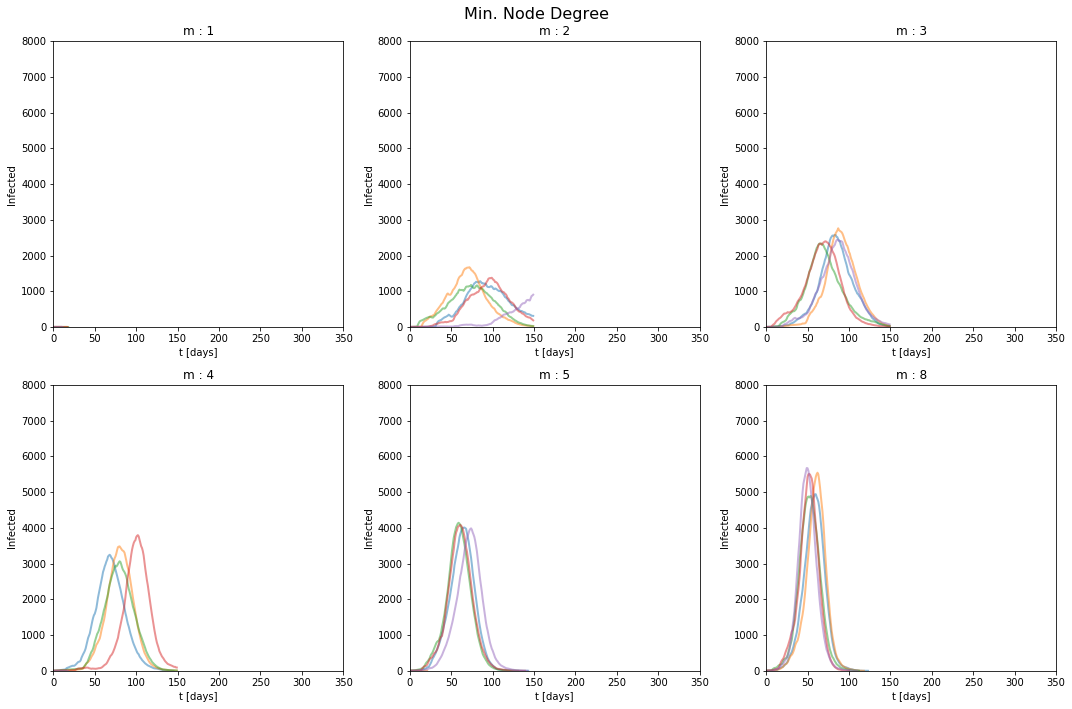

In [12]:
plot_infection(all_results_m, scan)

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results, axs.ravel(), scan._par_range):
    for res, g in results:
        mus = []
        for node in g:
            inter = 0
            for adj in g[node]:
                if adj not in g.nodes[node]["community"]:
                    inter += 1
            mus.append(inter / g.degree(node))
        sns.distplot(mus, ax=ax)
        #ax.set_yscale("log")
        #ax.set_xscale("log")
fig.suptitle("Mu Histograms", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_ba_par_scan_m_mu_hist.png", dpi=150)

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results, axs.ravel(), scan._par_range):
    for res, g in results:
        
        deg_hist = nx.degree_histogram(g)
        ax.step(np.arange(1, len(deg_hist)+2), np.append(deg_hist, [deg_hist[-1]]), alpha=0.3)
        ax.set_yscale("log")
        ax.set_xscale("log")
fig.suptitle("Degree Histograms", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_ba_par_scan_m_deg_hist.png", dpi=150)

In [30]:
conf = deepcopy(my_config)

ratio = 2

a = 7.8 / (0.1 + 0.9*ratio)
b = ratio * a
conf["population"]["nx"]["inter freq pdf"]["mean"] = a
conf["population"]["nx"]["intra freq pdf"]["mean"] = b
contagion = Contagion(conf)

g = contagion.pop._graph
rate_per_node = []
for node in g:
    rate_per_node.append(sum([val["weight"] for _, val in dict(g[node]).items()]))

print(np.average(rate_per_node))

4.105263157894736 8.210526315789473
7.811963460756932


In [28]:
0.1*4 + 0.9*9

8.5

In [ ]:
ratio

0.1 * 


In [13]:
scan = ScanPrefAttachMu(my_config)
all_results = []
for conf in scan:
    results = []
    for i in range(3):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results.append(results)


No change for five steps. Current mu:  0.05082332176738402  Target:  0.05


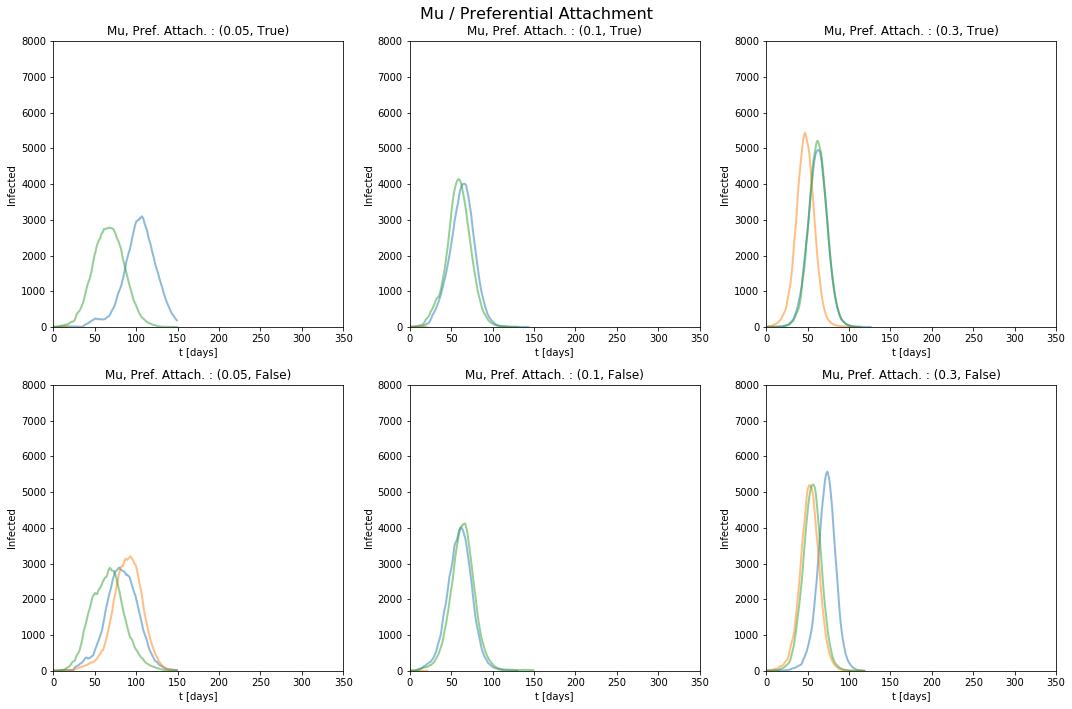

In [14]:
plot_infection(all_results, scan)

In [15]:
scan = ScanIntraInterRatio(my_config)
all_results = []
for conf in scan:
    results = []
    for i in range(5):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        rate_per_node = []
        for node in g:
            rate_per_node.append(sum([val["weight"] for _, val in dict(g[node]).items()]))
        #print(np.average(rate_per_node))
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results.append(results)


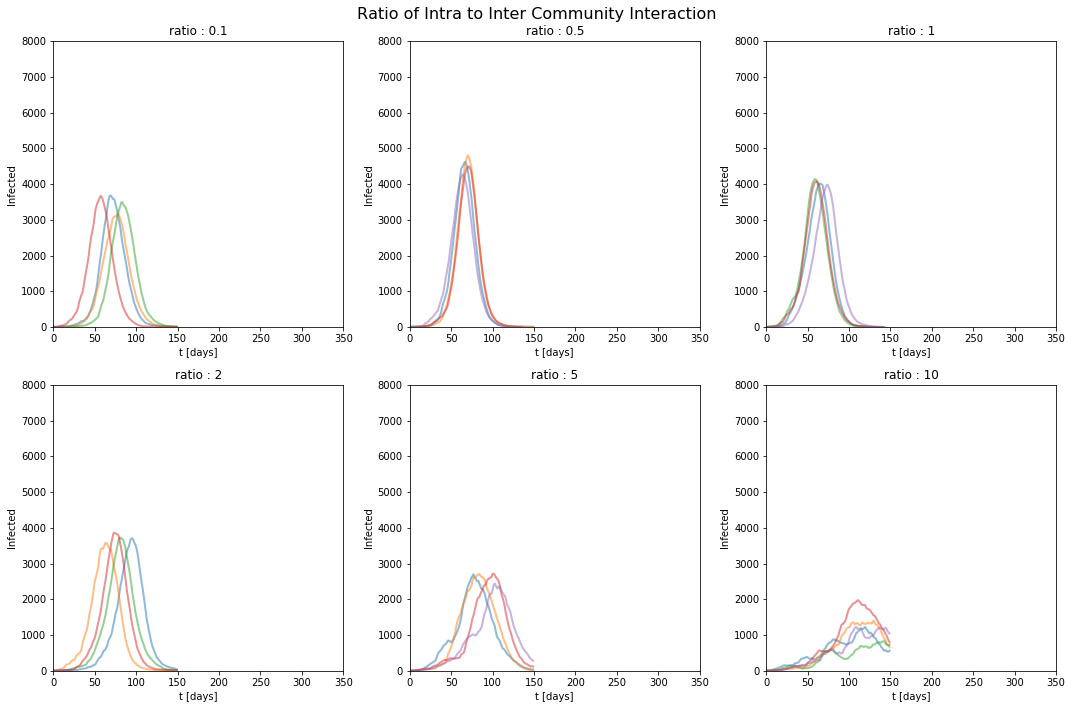

In [16]:
plot_infection(all_results, scan)

In [39]:
scan = ScanIntraInterRatio(my_config, mu=0.3)
all_results = []
for conf in scan:
    results = []
    for i in range(3):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        rate_per_node = []
        for node in g:
            rate_per_node.append(sum([val["weight"] for _, val in dict(g[node]).items()]))
        print(np.average(rate_per_node))
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results.append(results)


7.804793344476487
7.787338062246624
7.7981508875335335
7.825026697140414
7.79726284322795
7.81167461340157
7.813190067994775
7.799835859506295
7.824888995422798
7.819592382818684
7.796191289286342
7.826917312933594
7.833562723489185
7.809725137591954
7.826143541995497
7.850046806143074
7.818266464704456
7.832972778680793


In [41]:
inter_weights = []
intra_weights = []
for u,v  in g.edges:
    if v in g.nodes[u]["community"]:
        intra_weights.append(g.edges[(u, v)]["weight"])
    else:
        inter_weights.append(g.edges[(u, v)]["weight"])
        
        

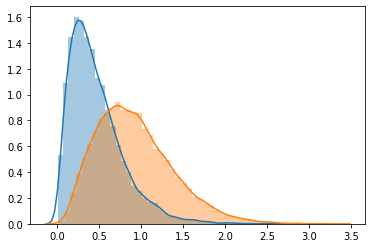

In [43]:
sns.distplot(inter_weights)
sns.distplot(intra_weights)

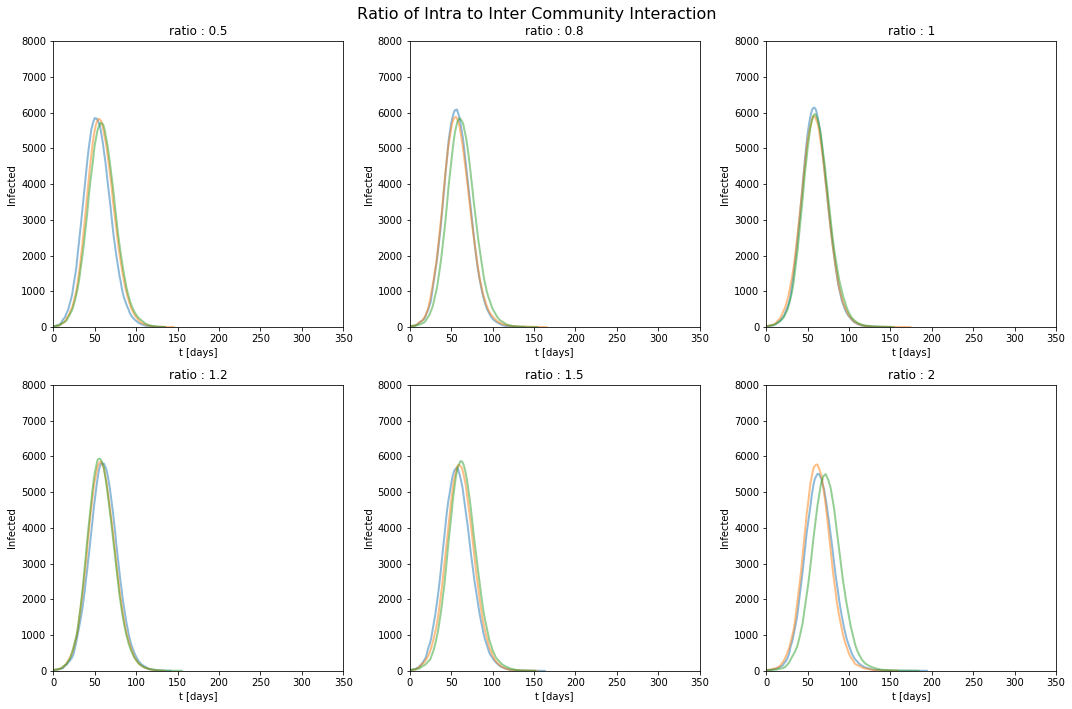

In [40]:
plot_infection(all_results, scan)

In [45]:
scan = ScanIntraInterRatio(my_config, mu=0.5)
all_results = []
for conf in scan:
    results = []
    for i in range(3):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        rate_per_node = []
        for node in g:
            rate_per_node.append(sum([val["weight"] for _, val in dict(g[node]).items()]))
        print(np.average(rate_per_node))
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results.append(results)


7.734231559318468
7.772103313474758
7.764660279953151
7.778162523007591
7.7689959638161366
7.773234605150165
7.801883811937904
7.793201894608318
7.832405570632119
7.825231808130147
7.7961410595924985
7.842880995307793
7.865710037734837
7.825498847132587
7.856710968761811
7.8647001790800175
7.805551936773541
7.8645119491970155


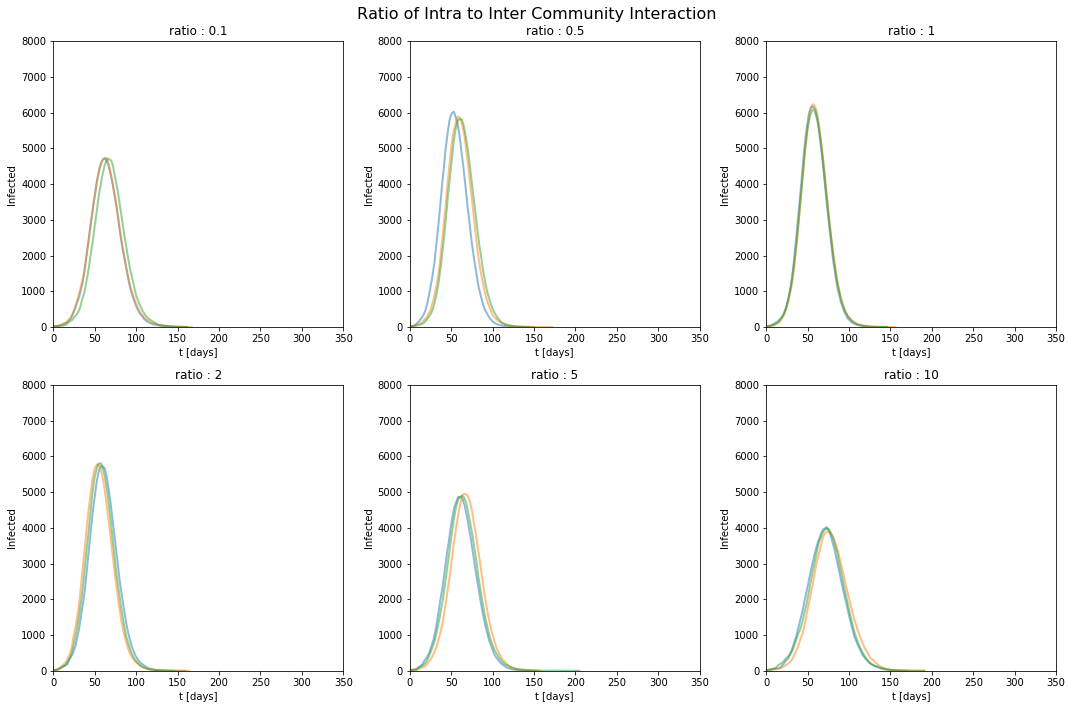

In [46]:
plot_infection(all_results, scan)

In [ ]:
g = contagion.pop._graph


In [8]:
scan = ScanRndIntNumConstRate(my_config)
all_results_n_rnd_ctc_rate5 = []
for conf in scan:
    results = []
    for i in range(10):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_n_rnd_ctc_rate5.append(results)

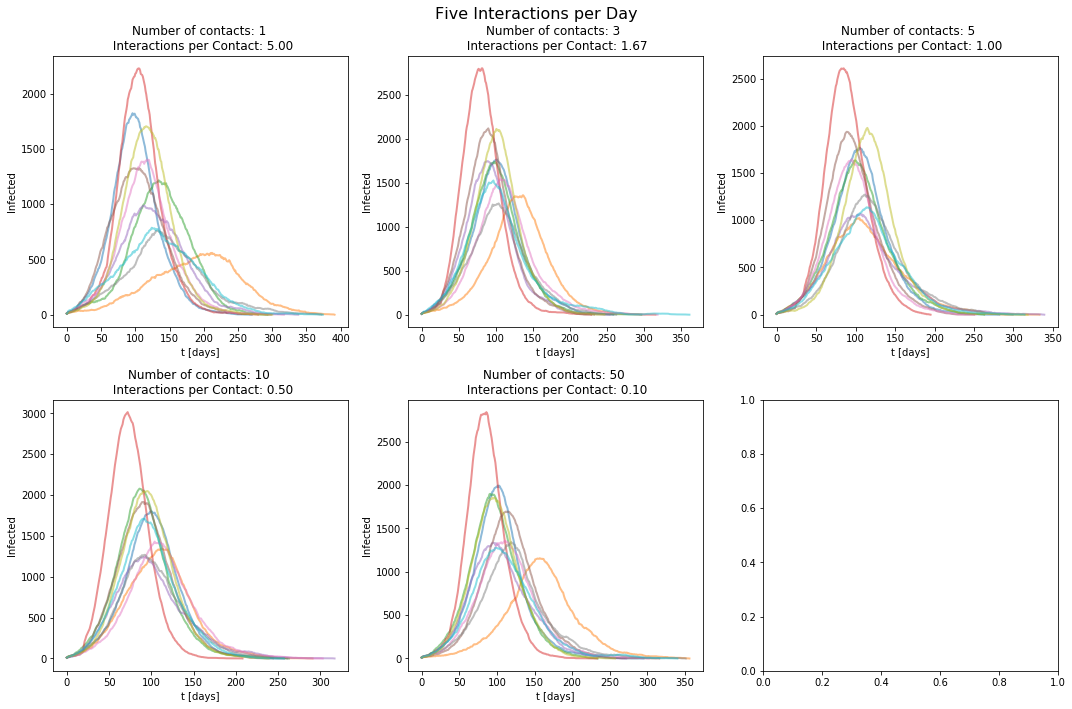

In [26]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results_n_rnd_ctc_rate5, axs.ravel(), scan._par_range):
    for res, _ in results:
        ax.plot(np.arange(len(res['is_infected'])), res['is_infected'],
                lw=2, alpha=0.5)
#ax.set_yscale("log")
        ax.set_xlabel("t [days]")
        ax.set_ylabel("Infected")
        ax.set_title("Number of contacts: {} \n Interactions per Contact: {:.2f}".format(scan_par, 5/scan_par))
fig.suptitle("Five Interactions per Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_par_scan_n_rnd_ctc_5rnd_ctc.png", dpi=150)

In [29]:
scan = ScanRndIntIntConstRate(my_config)
all_results_n_rnd_int_rate5 = []
for conf in scan:
    results = []
    for i in range(10):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_n_rnd_int_rate5.append(results)

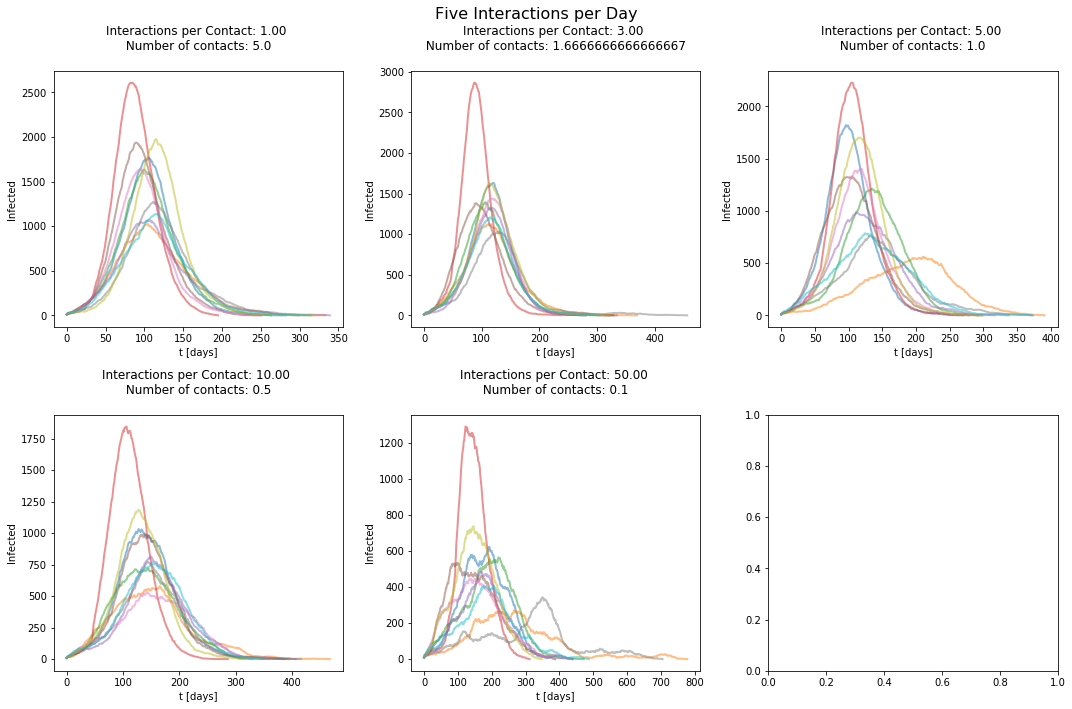

In [30]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results_n_rnd_int_rate5, axs.ravel(), scan._par_range):
    for res, _ in results:
        ax.plot(np.arange(len(res['is_infected'])), res['is_infected'],
                lw=2, alpha=0.5)
#ax.set_yscale("log")
        ax.set_xlabel("t [days]")
        ax.set_ylabel("Infected")
        ax.set_title("Interactions per Contact: {:.2f} \n Number of contacts: {} \n".format(scan_par, 5/scan_par))
fig.suptitle("Five Interactions per Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_par_scan_n_rnd_int_5rnd_ctc.png", dpi=150)